# Analyzing Simulated Taxpayer Behavior Using PySpark
This notebook clusters taxpayer profiles based on behavior and risk factors using PySpark.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("TaxpayerBehaviorClustering") \
    .getOrCreate()

## Load and Inspect Data

In [3]:
df = spark.read.csv("simulated_taxpayer_data.csv", header=True, inferSchema=True)
df.show(5)
df.printSchema()

+-----------+------+-----------------+--------------------+----------+------+
|taxpayer_id|income|filing_delay_days|underreporting_score|audit_flag|region|
+-----------+------+-----------------+--------------------+----------+------+
|     TP1000|103810|               42|                0.06|         0|  West|
|     TP1001| 34592|               40|                0.02|         0|  East|
|     TP1002| 23278|               21|                0.55|         0|  East|
|     TP1003|117196|               29|                0.59|         1|  West|
|     TP1004| 56048|                4|                0.01|         0| North|
+-----------+------+-----------------+--------------------+----------+------+
only showing top 5 rows

root
 |-- taxpayer_id: string (nullable = true)
 |-- income: integer (nullable = true)
 |-- filing_delay_days: integer (nullable = true)
 |-- underreporting_score: double (nullable = true)
 |-- audit_flag: integer (nullable = true)
 |-- region: string (nullable = true)



## Data Cleaning and Preprocessing

In [4]:
from pyspark.sql.functions import col

df_clean = df.dropna()
df_clean = df_clean.withColumn("audit_flag", col("audit_flag").cast("int"))

## Feature Engineering

In [5]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["income", "filing_delay_days", "underreporting_score", "audit_flag"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(df_clean)

## Clustering with KMeans

In [6]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(df_vector)
clustered = model.transform(df_vector)
clustered.select("taxpayer_id", "cluster").show(10)

+-----------+-------+
|taxpayer_id|cluster|
+-----------+-------+
|     TP1000|      3|
|     TP1001|      2|
|     TP1002|      2|
|     TP1003|      0|
|     TP1004|      1|
|     TP1005|      1|
|     TP1006|      1|
|     TP1007|      2|
|     TP1008|      0|
|     TP1009|      2|
+-----------+-------+
only showing top 10 rows



## Analyze Clusters

In [7]:
clustered.groupBy("cluster").avg("income", "filing_delay_days", "underreporting_score").show()

+-------+------------------+----------------------+-------------------------+
|cluster|       avg(income)|avg(filing_delay_days)|avg(underreporting_score)|
+-------+------------------+----------------------+-------------------------+
|      1| 59194.68965517241|    30.586206896551722|        0.390344827586207|
|      3| 95398.33333333333|     21.61904761904762|       0.4414285714285714|
|      2|31205.260869565216|    28.956521739130434|       0.3878260869565218|
|      0|127116.88888888889|     28.59259259259259|       0.5366666666666666|
+-------+------------------+----------------------+-------------------------+



## Optional: Visualization

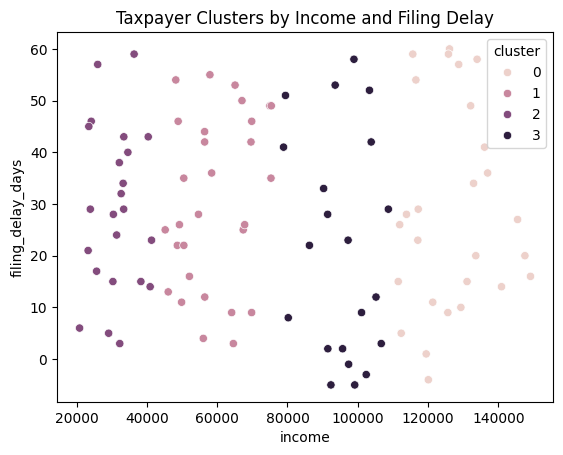

In [8]:
pandas_df = clustered.select("income", "filing_delay_days", "cluster").toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=pandas_df, x="income", y="filing_delay_days", hue="cluster")
plt.title("Taxpayer Clusters by Income and Filing Delay")
plt.show()

## Save Results

In [10]:
# Drop the 'features' column before saving as CSV, as it's not a supported type for CSV
clustered_for_save = clustered.drop("features")

# Save the modified DataFrame to CSV
clustered_for_save.write.csv("clustered_taxpayer_profiles.csv", header=True, mode="overwrite")